In [ ]:
import pickle, os, sys, re
from glob import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


sys.path.append("..")
from utils import plot_mat_comp, flatten_triang, unflatten_triang, flatten_triang_batch, unflatten_triang_batch, perform_calculation, density_from_fock

In [2]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap

In [3]:
source_path = '../../datasets/QM9/xyz_c5h4n2o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

509

In [4]:
focks = []
used_files = []
reference_densities = []
overlaps = []
for file in all_file_paths:
    mol_name = os.path.basename(file).split(".")[0]
    # print(mol_name)
    ret = density_fock_overlap(filepath = file,
                         filename = mol_name,
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")
    if any([r == None for r in ret]): 
        print(f"File {mol_name} bad - skipping")
        continue
    focks.append(ret[1].numpy)
    used_files.append(file)
    reference_densities.append(ret[0].numpy)
    overlaps.append(ret[2].numpy)
print(f"Using {len(focks)} files from {len(all_file_paths)} total files")

df = pd.DataFrame({"file": used_files, "fock": focks, "density": reference_densities, "overlap": overlaps})

File dsgdb9nsd_057125 bad - skipping
Using 508 files from 509 total files


## Add some noise and then test convergence of noisy fock

In [41]:
# add normal noise
df["fock_noise"] = df["fock"].apply(lambda x: x + np.random.normal(0, 0.2, x.shape))

Sampled file: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_026806.xyz


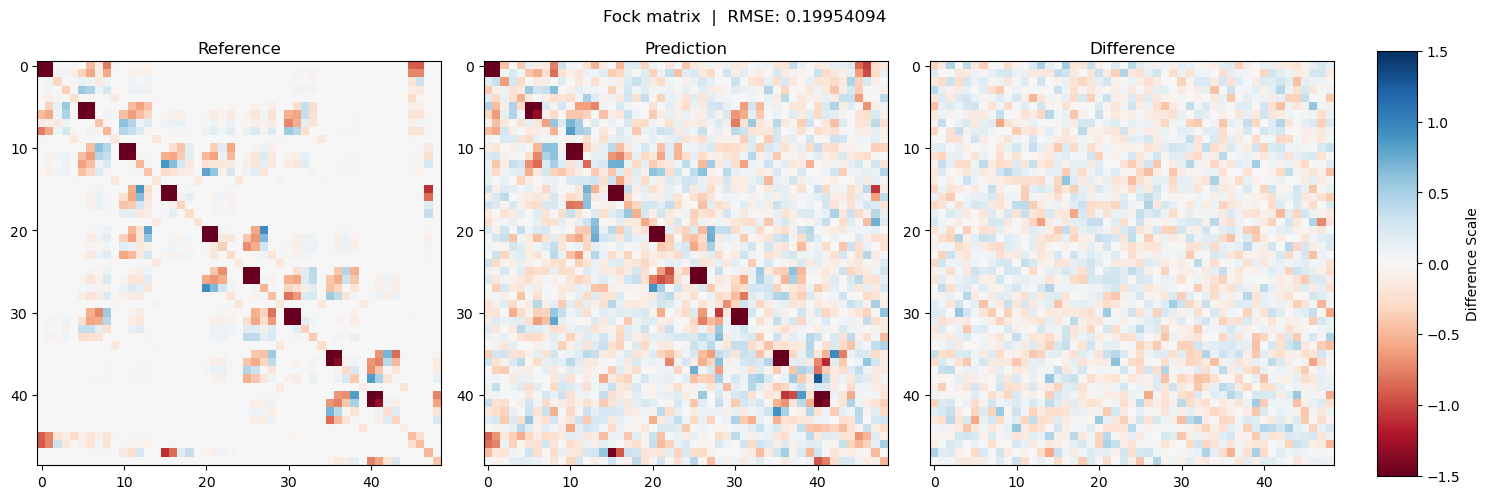

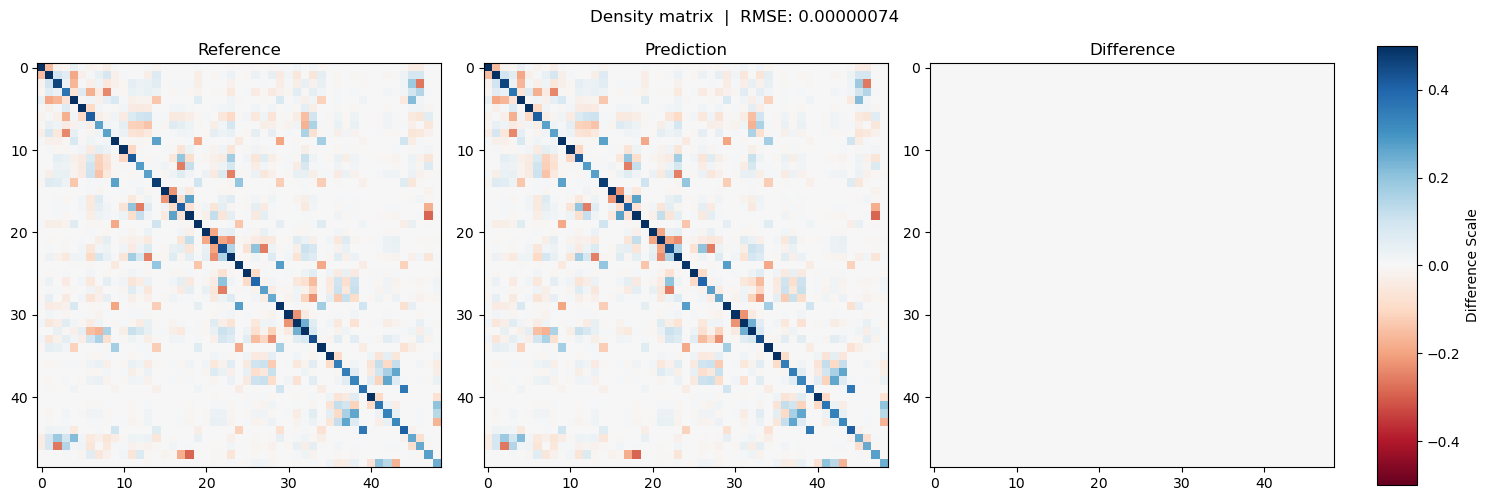

In [42]:
# example
sample = np.random.randint(0, len(df))
print(f"Sampled file: {df.iloc[sample]['file']}")
fock, noisy_fock = df.iloc[sample]["fock"], df.iloc[sample]["fock_noise"]
plot_mat_comp(fock, noisy_fock, title = "Fock matrix")
ref_density = density_from_fock(fock, df.iloc[sample]["overlap"], 32)
plot_mat_comp(ref_density, df.iloc[sample]["density"], title = "Density matrix", vmax=0.5)

# Ok let's get a reference using PySCF

In [27]:
from pyscf.gto import Mole
from pyscf import scf

In [ ]:
file = df.iloc[sample]["file"]
refernce_density = df.iloc[sample]["density"]

lines = open(file).readlines()
q = int(re.search(r"charge\s+(-?\d+)", lines[1]).group(1))
m = int(re.search(r"multiplicity\s+(\d+)", lines[1]).group(1))

mol = Mole(atom=file, charge=q, spin = m-1, symmetry = False)
mol.basis = "sto-3g"
mol.build()

mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.init_guess = "minao"
mf.kernel()

print(f"Took {mf.cycles} cycles to converge")
pydensity = mf.make_rdm1()

# now start with converged density! 
mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.kernel(dm0=2*refernce_density)
print(f"Took {mf.cycles} cycles to converge")

# now start with density from converged fock!
density_from_ref_fock = density_from_fock(fock, df.iloc[sample]["overlap"], 32)
mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.kernel(dm0=2*density_from_ref_fock)
print(f"Fock: Took {mf.cycles} cycles to converge")

density_from_ref_fock = density_from_fock(noisy_fock, df.iloc[sample]["overlap"], 32)
mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.kernel(dm0=2*density_from_ref_fock)
print(f"Noisy Fock: Took {mf.cycles} cycles to converge")

# plot_mat_comp(pydensity, 2*refernce_density, title = "Density matrix", vmax=0.5)

converged SCF energy = -446.83570024678
Took 11 cycles to converge
converged SCF energy = -446.83570024695
Took 4 cycles to converge
converged SCF energy = -446.835700246949
Took 4 cycles to converge
converged SCF energy = -446.835700246927
Took 17 cycles to converge


Ok noise has an impact - obviously let's check how much!

converged SCF energy = -446.83570024695
Noise 0.0: Took 4 cycles to converge
converged SCF energy = -446.835700246864
Noise 0.011111111111111112: Took 11 cycles to converge
converged SCF energy = -446.835700246893
Noise 0.022222222222222223: Took 12 cycles to converge
converged SCF energy = -446.835700246865
Noise 0.03333333333333333: Took 13 cycles to converge
converged SCF energy = -446.835700246934
Noise 0.044444444444444446: Took 13 cycles to converge
converged SCF energy = -446.835700246946
Noise 0.05555555555555556: Took 14 cycles to converge
converged SCF energy = -446.835700246952
Noise 0.06666666666666667: Took 14 cycles to converge
converged SCF energy = -446.835700246813
Noise 0.07777777777777778: Took 15 cycles to converge
converged SCF energy = -446.835700246905
Noise 0.08888888888888889: Took 13 cycles to converge
converged SCF energy = -446.835700246823
Noise 0.1: Took 33 cycles to converge


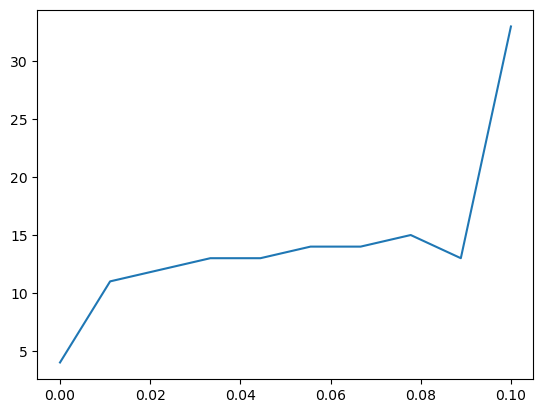

In [ ]:
noises = np.linspace(0, 0.1, 10)
cycles = []
for noise in noises: 
    noisy_fock = df.iloc[sample]["fock"] + np.random.normal(0, noise, df.iloc[sample]["fock"].shape)
    density_from_ref_fock = density_from_fock(noisy_fock, df.iloc[sample]["overlap"], 32)
    mf = scf.RKS(mol)
    mf.xc = "b3lypg"
    mf.kernel(dm0=2*density_from_ref_fock)
    print(f"Noise {noise}: Took {mf.cycles} cycles to converge")
    cycles.append(mf.cycles)

Text(0, 0.5, 'Cycles')

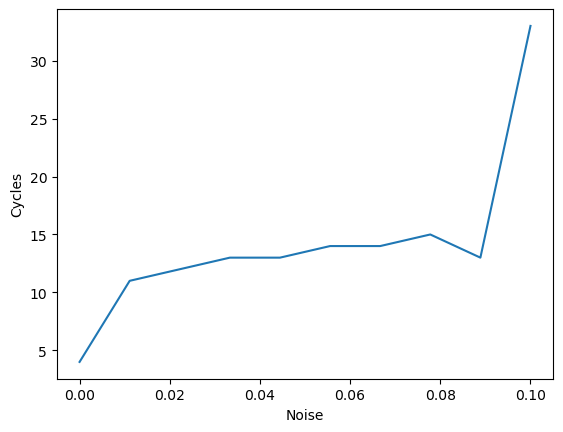

In [ ]:
import matplotlib.pyplot as plt
plt.plot(noises, cycles)
plt.xlabel("Noise (uniform)")
plt.ylabel("Cycles")

In [46]:
noises = np.linspace(0, 0.1, 10)
cycles = []
for noise in noises: 
    noisy_fock = df.iloc[sample]["fock"].copy()
    np.fill_diagonal(noisy_fock, noisy_fock.diagonal() + np.random.normal(0, noise, noisy_fock.shape[0]))
    density_from_ref_fock = density_from_fock(noisy_fock, df.iloc[sample]["overlap"], 32)
    mf = scf.RKS(mol)
    mf.xc = "b3lypg"
    mf.kernel(dm0=2*density_from_ref_fock)
    print(f"Noise {noise}: Took {mf.cycles} cycles to converge")
    cycles.append(mf.cycles)

converged SCF energy = -446.835700246948
Noise 0.0: Took 4 cycles to converge
converged SCF energy = -446.83570024694
Noise 0.011111111111111112: Took 10 cycles to converge
converged SCF energy = -446.835700246921
Noise 0.022222222222222223: Took 10 cycles to converge
converged SCF energy = -446.835700246917
Noise 0.03333333333333333: Took 11 cycles to converge
converged SCF energy = -446.835700246873
Noise 0.044444444444444446: Took 12 cycles to converge
converged SCF energy = -446.835700246934
Noise 0.05555555555555556: Took 11 cycles to converge
converged SCF energy = -446.835700246239
Noise 0.06666666666666667: Took 11 cycles to converge
converged SCF energy = -446.835700246921
Noise 0.07777777777777778: Took 11 cycles to converge
converged SCF energy = -446.835700246867
Noise 0.08888888888888889: Took 16 cycles to converge
converged SCF energy = -446.835700246878
Noise 0.1: Took 14 cycles to converge


Text(0, 0.5, 'Cycles')

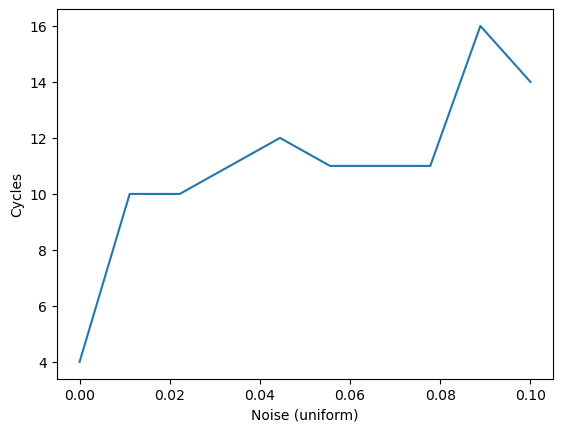

In [47]:
plt.plot(noises, cycles)
plt.xlabel("Noise (uniform)")
plt.ylabel("Cycles")

If we have a density which is really close -> very fast convergence